### Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim

In [127]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
import seaborn as sns
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

<h1> Data Preprocessing & Exploration </h1>

In [128]:
# Read in csv file
df = pd.read_csv("./data/genres.csv", low_memory=False)

In [129]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]
df_dt = df.copy() # Saved for decision tree.

In [130]:
# One hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,0,0,1,0
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,0,0,1,0
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,0,0,1,0
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,0,1,0,0
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,0,0,1,0
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,0,0,1,0
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,0,0,1,0
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,0,0,1,0


In [131]:
# Separate data into features and class labels
features = df.drop('genre', axis=1)
labels = df['genre']

In [132]:
print(features.head())
print()
label_groups = df.groupby('genre')
unique_genres = sorted(list(set(list(labels))))
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  \
0          0.013400    0.0556   0.3890  156.985       124539   
1          0.000000    0.1180   0.1240  115.080       224427   
2          0.000004    0.3720   0.0391  218.050        98821   
3          0.000000    0.1140   0.1750  186.948       123661   
4          0.000000    0.1660   0.5910  147.988       123298   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0                 0                 0                 1                 0  
1           

In [133]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

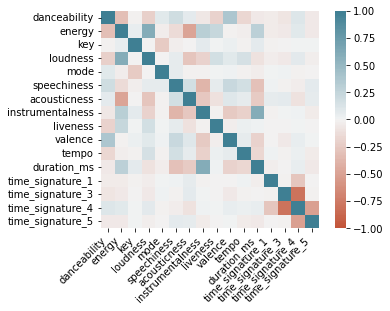

In [134]:
# Plot correlation between features.
ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [135]:
# Perform anomaly detection.
y_pred_list = []

# Probabilistic anomaly detection.
envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# Proximity-based anomaly detection.
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# Density-based anomaly detection.
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

Counter({1: 38074, -1: 4231})
Counter({1: 38023, -1: 4282})
Counter({1: 40473, -1: 1832})

genre
Dark Trap          3191
Emo                1245
Hiphop             2037
Pop                 362
Rap                1291
RnB                1410
Trap Metal         1419
Underground Rap    4310
dnb                2758
hardstyle          2664
psytrance          2703
techhouse          2789
techno             2479
trance             2767
trap               2727
dtype: int64

Size of new dataset: 34152


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

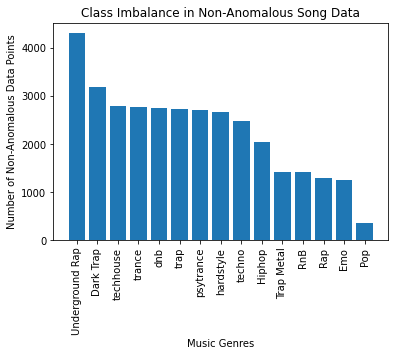

In [136]:
# Drop anomalous points.
features_no_anomalies = features.copy()
labels_no_anomalies = labels.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups = labels_no_anomalies.groupby('genre')
print()
print(label_groups.size())
print("\nSize of new dataset: %i" % len(features_no_anomalies))

# Display class imbalance with bar graph.
sorted_labels = label_groups.size().sort_values(ascending=False)
sorted_labels = sorted_labels.reset_index()
plt.bar(sorted_labels['genre'], sorted_labels[0])
plt.title('Class Imbalance in Non-Anomalous Song Data')
plt.xlabel('Music Genres')
plt.ylabel('Number of Non-Anomalous Data Points')
plt.xticks(rotation=90)

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


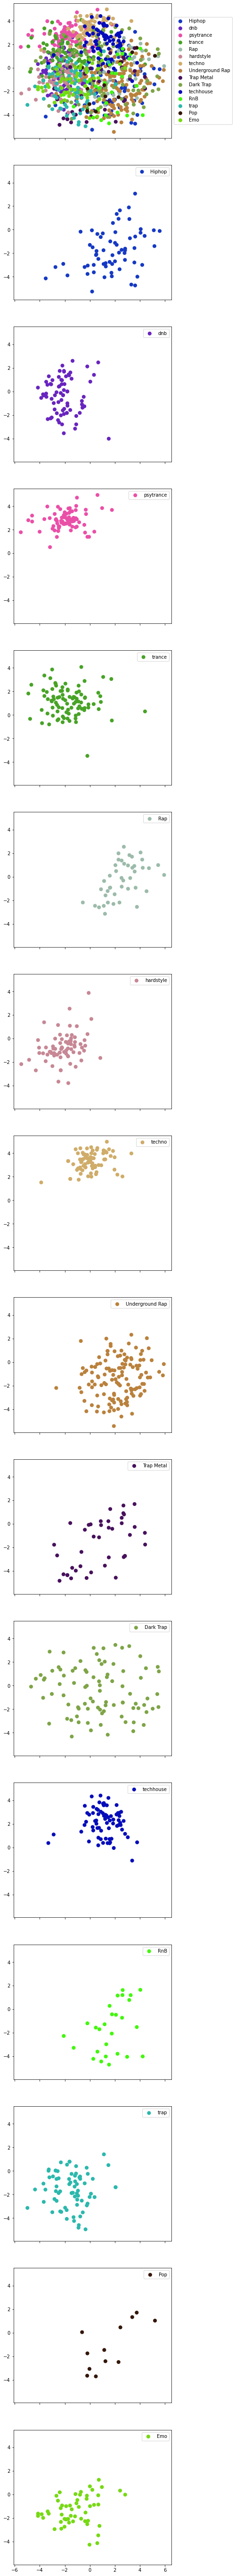

In [137]:
# Modified code from scatter() function from HW 5.
# Print the labeled data clusters after anomalies taken out.

# Scale non-anomalous data.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_no_anomalies)
pca = PCA(n_components=0.95, svd_solver='full')
features_scaled = pca.fit_transform(features_scaled)

# Sample subset of scaled data points.
numPoints = 1000
numEntries = features_scaled.shape[0]
samp_records = []
samp_labels = []
for i in range(numPoints):
    index = random.randint(0, numEntries - 1)
    samp_records.append(features_scaled[index, :])
    samp_labels.append(labels_no_anomalies.iloc[index, 0])

# Generate different color for each genre.
label_colors = []
color_dict = dict()
for label in samp_labels:
    if not label in color_dict.keys():
        # noanominally found in https://stackoverflow.com/questions/28999287/generate-random-colors-rgb.
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        color_dict[label] = color
    label_colors.append(color_dict[label])

# Project sampled data down onto 2 dimensions to visualize similarity.
mds = MDS(n_components=2)
mds_data = mds.fit_transform(samp_records)

# Assign label for each data point.
classes = dict()
for i in range(len(mds_data)):
    record = mds_data[i]
    label = samp_labels[i]
    if not label in classes.keys():
        classes[label] = [record]
    else:
        classes[label].append(record)

# Plot cluster of sampled data for each individual genre.
fig, axes = plt.subplots(len(classes.keys()) + 1, 1, figsize=(6, 100), sharey=True, sharex=True)
index = 1
for genre in classes.keys():
    ax = axes[index]
    index += 1
    data = pd.DataFrame(classes[genre])
    color = [color_dict[genre] for i in range(len(data))]
    axes[0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)

# Originally found in https://towardsdatascience.com/legend-outside-the-plot-matplotlib-5d9c1caa9d31#:~:text=Placing%20the%20legend%20outside%20of%20the%20plot&text=First%2C%20we%20need%20to%20shrink,control%20for%20manual%20legend%20placement.&text=Box%20that%20is%20used%20to,Defaults%20to%20axes.
axes[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
index = 1

# Plot all genres onto one scatterplot.
while index <= len(classes.keys()):
    ax = axes[index]
    ax.legend(loc='best')
    index += 1

In [138]:
# Downsample data to mitigate for class imbalance.
min_size = math.inf
for genre in label_groups.groups.keys():
    genre_group = label_groups.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features = pd.DataFrame(samp_records).set_index('index')
samp_genres = pd.DataFrame(samp_features['genre'])
samp_features = samp_features.drop('genre', axis=1)
print(samp_features)
print(samp_genres)

for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)

print("Balanced downsampled labels:")
print(samp_genres.groupby('genre').size())

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
index                                                                         
813           0.900   0.783   10    -4.498     0       0.2280       0.00373   
1168          0.882   0.545    0    -6.977     1       0.2900       0.27300   
1811          0.703   0.661    7    -7.359     0       0.0408       0.01120   
2791          0.773   0.815    9    -7.762     1       0.0614       0.00106   
2311          0.620   0.932    8    -6.303     1       0.0438       0.01320   
...             ...     ...  ...       ...   ...          ...           ...   
27080         0.575   0.961    1    -1.888     0       0.1760       0.00897   
26879         0.591   0.901   10    -1.039     0       0.0761       0.00371   
27152         0.823   0.723    0    -7.540     1       0.4990       0.05090   
26004         0.407   0.908    1    -4.819     1       0.1120       0.00263   
26762         0.661   0.808    0    -5.067     1    

<h1> Model Building </h1>

### Naive Bayes

As part of our group's brainstorming process for which classifier types would be most appropriate to train our data on, we chose to try Naive Bayes since it is not susceptible to the curse of dimensionality (and we have a quite a few features we are using). Since Naive Bayes assumes that all features are conditionally independent of each other given the label and our features were weakly correlated with each other, we thought this was an additional reason this classifier could be appropriate.

Gaussian Naive Bayes was the only subtype of this classifier that we were able to use since it allowed for use of continuous feature values. Multinomial and Categorical required discrete feature values, Complement needed nonnegative values, and Bernoilli relied on binary feature values, so we couldn't use any of these while using all of our features (original and reduced dimensionality).

We first trained 2 different Gaussian Naive Bayes classifiers with 10-fold cross validation for all of our data and 
for our data without the anomalies detected during data exploration and cleaning. This was to determine how much anomalies skewed the classifier's feature probability distributions. 


In [139]:
# Create a Gaussian Naive Bayes classifier.
gnb = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = cross_val_score(gnb, features, list(labels), cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))


# Create a Gaussian Naive Bayes classifier for data without anomalies.
gnb_no_anomalies = GaussianNB()
labels_no_anomalies = labels_no_anomalies.iloc[:, 0]

# Run 10-fold cross validation on classifier for data without anomalies.
accuracies_no_anomalies = cross_val_score(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of the cross-validated model for data without anomalies.
avg_accuracy_no_anomalies = accuracies_no_anomalies.mean()
print("Accuracy without anomalies:", (avg_accuracy_no_anomalies * 100))

Accuracy: 49.334593870637356
Accuracy without anomalies: 52.280871002362495


Given our 15 genres to choose from in classification of a song in the dataset, a random classifier would have about a 6.67% chance of choosing a certain genre. Therefore, with our whole data classifier yielding ~49.3% accuracy and the non-anomalous classifier yielding ~52.3% accuracy, both classifiers performed significantly better than random. 

Also worth noting is the improvement in the accuracy of the classifier by 3% after removing anomalies, indicating that the of the ~8000 points we removed, there was some skewing of classes by anomalous feature values.

Due to the severe class imbalance between genres in this dataset, accuracy may not be an accurate depiction of the spread of classification performance across classes. Therefore, we wanted to take a look at the classification matrix and report of other evaluation metrics to investigate the performance of our classifiers.

In [140]:
# Plot the confusion matrix in a more visually appealing heat map.
def plot_confusion_matrix(confusion_mat):
    ax = plt.subplot()
    sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)
    
    unique_labels = sorted(list(set(list(labels))))

    # Labels, title and ticks.
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(unique_genres, rotation=90)
    ax.yaxis.set_ticklabels(unique_genres, rotation=0)


Classification Report with Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.32      0.03      0.06      4578
            Emo       0.00      0.00      0.00      1680
         Hiphop       0.36      0.23      0.28      3028
            Pop       0.00      0.00      0.00       461
            Rap       0.50      0.29      0.37      1848
            RnB       0.00      0.00      0.00      2099
     Trap Metal       0.49      0.01      0.03      1956
Underground Rap       0.34      0.65      0.44      5875
            dnb       0.72      0.99      0.83      2966
      hardstyle       0.48      0.90      0.63      2936
      psytrance       0.76      0.92      0.83      2961
      techhouse       0.46      0.76      0.57      2975
         techno       0.68      0.80      0.73      2956
         trance       0.40      0.44      0.42      2999
           trap       0.55      0.48      0.51      2987

       accuracy                           0.49

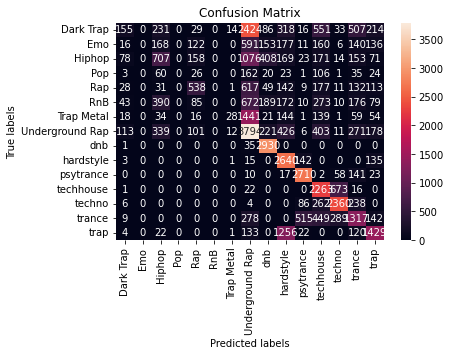

In [141]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the whole data classifier.
pred_labels = cross_val_predict(gnb, features, labels, cv=10)
con_mat = confusion_matrix(labels, pred_labels)
plot_confusion_matrix(con_mat)

# Display the classification report for the whole data Naive Bayes classifier.
report = classification_report(labels, pred_labels, zero_division=0)
print("\nClassification Report with Anomalies:\n", report)


Classification Report without Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.20      0.01      0.02      3191
            Emo       0.00      0.00      0.00      1245
         Hiphop       0.37      0.25      0.30      2037
            Pop       0.00      0.00      0.00       362
            Rap       0.46      0.19      0.27      1291
            RnB       0.00      0.00      0.00      1410
     Trap Metal       0.56      0.02      0.04      1419
Underground Rap       0.36      0.61      0.45      4310
            dnb       0.75      0.99      0.85      2758
      hardstyle       0.50      0.89      0.64      2664
      psytrance       0.77      0.92      0.84      2703
      techhouse       0.49      0.77      0.60      2789
         techno       0.67      0.78      0.72      2479
         trance       0.42      0.48      0.45      2767
           trap       0.57      0.50      0.53      2727

       accuracy                           0

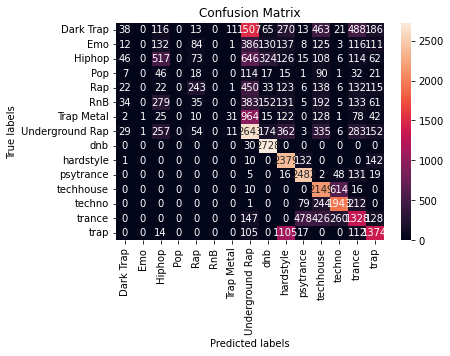

In [142]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier without anomalies.
pred_labels_no_anomalies = cross_val_predict(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)
con_mat_no_anomalies = confusion_matrix(labels_no_anomalies, pred_labels_no_anomalies)
plot_confusion_matrix(con_mat_no_anomalies)

# Display the classification report for the Naive Bayes classifier without anomalies.
report_no_anomalies = classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0)
report_no_anomalies_dict = classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0, output_dict=True)
print("\nClassification Report without Anomalies:\n", report_no_anomalies)

Between the 2 classification reports, both classifiers seem to especially struggle with Emo, Pop, and RnB, having classified 0 songs as these genres, despite more than a 1000 songs in either dataset being Emo and RnB and all of these genres being relatively distinct and recognizable to the human ear. Similarly surprising was the f1 score being unusually low (0.06 with anomalies and 0.02 without) for Dark Trap despite having the 2nd largest amount of songs in this genre in the data. Psytrance and dnb had f1 scores from 0.83-0.85 in either classifier despite a moderate amount of points in each genre.

From these observations, we decided to investigate the relationship between cohesion (with relation to number of points in each genre) of the non-anomalous classes and the f1 scores with Gaussian Naive Bayes. Since Naive Bayes assumes that each feature is independent of each other and relies on probability distributions for each feature, perhaps the so-so performance could be attributed to similar feature values across genres.

Also, due to the variety in f1 scores across imbalanced genres, we decided to try Naive Bayes with a downsampled dataset with non-anomalous data.

In [143]:
rel_cohesion = dict()
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies

# Calculate the cohesion (similarity) between points in each genre.
for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)
    for i in range(0, len(data)):
        # Sum WSS over each data point in current cluster.
        record = data.iloc[i, :]
        cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
    print("The cohesion of records in %s is %f." % (genre, cohesion))
    print("The cohesion of records in %s, relative to size, is %f.\n" % (genre, (cohesion / len(data))))
    rel_cohesion[genre] = cohesion / len(data)
    
# Sum WSS over all genres.
total_cohesion = 0
total_c = np.mean(features_no_anomalies, axis=0)
for i in range(len(features_no_anomalies)):
    record = features_no_anomalies.iloc[i, :]
    total_cohesion += (math.sqrt(((record[0] - total_c[0]) ** 2) + (record[1] - total_c[1]) ** 2)) ** 2

rel_total = total_cohesion / len(features_no_anomalies)
print("The cohesion of all records is %f." % (total_cohesion))
print("The relative cohesion of all records is %f." % (rel_total))

The cohesion of records in Hiphop is 75.016596.
The cohesion of records in Hiphop, relative to size, is 0.036827.

The cohesion of records in dnb is 55.675599.
The cohesion of records in dnb, relative to size, is 0.020187.

The cohesion of records in psytrance is 42.973413.
The cohesion of records in psytrance, relative to size, is 0.015898.

The cohesion of records in trance is 56.078879.
The cohesion of records in trance, relative to size, is 0.020267.

The cohesion of records in Rap is 37.491620.
The cohesion of records in Rap, relative to size, is 0.029041.

The cohesion of records in hardstyle is 43.822457.
The cohesion of records in hardstyle, relative to size, is 0.016450.

The cohesion of records in techno is 59.402191.
The cohesion of records in techno, relative to size, is 0.023962.

The cohesion of records in Underground Rap is 153.937250.
The cohesion of records in Underground Rap, relative to size, is 0.035716.

The cohesion of records in Trap Metal is 68.282688.
The cohes

In [144]:
# Compute the correlation between Naive Bayes f1 score and relative cohesion of class for non-anomalous data.
genre_f1 = dict()
genres_dict = df.groupby('genre').groups.keys()
corr_df = []
for genre in genres_dict:
    metrics = report_no_anomalies_dict[genre]
    f1 = metrics['f1-score']
    corr_df.append([f1, rel_cohesion[genre]])

corr_df = pd.DataFrame(corr_df, index=genres_dict, columns=['f1-score', 'Relative Cohesion'])
print(corr_df.corr())

                   f1-score  Relative Cohesion
f1-score           1.000000          -0.777925
Relative Cohesion -0.777925           1.000000


The f1 score from Naive Bayes classification and relative cohesion (without anomalies) of each genre appears to be moderately to highly negatively correlated. Cohesion measures the proximity of each point in a cluster to its centroid, so lower cohesion of songs within their actual genres means that songs are more similar to each other. F1 score combines the precision and recall metrics of classification so that a score of 0 is the worst performance and 1 is the best. Therefore, it makes sense for our performance metric f1 score to be negatively correlated to cohesion, as our classifier should have an easier time discerning between genres (higher f1 score) when songs in a genre tend to be more similar to each other (lower cohesion).

Therefore, the performance of our Naive Bayes classifier seems to be moderately to highly influenced by the similarity of songs within a genre.

We will lastly train a Gaussian Naive Bayes classifier to determine the effect of class imbalance on the classifier's performance.

Accuracy with Sampled/Balanced Non-Anomalous Data: 45.322283609576424

Classification Report with Sampled/Balanced Non-Anomalous Data:
                  precision    recall  f1-score   support

      Dark Trap       0.25      0.05      0.09       362
            Emo       0.35      0.19      0.25       362
         Hiphop       0.40      0.25      0.30       362
            Pop       0.22      0.22      0.22       362
            Rap       0.33      0.25      0.29       362
            RnB       0.25      0.01      0.03       362
     Trap Metal       0.32      0.54      0.40       362
Underground Rap       0.30      0.07      0.11       362
            dnb       0.71      0.98      0.82       362
      hardstyle       0.45      0.92      0.60       362
      psytrance       0.74      0.90      0.81       362
      techhouse       0.41      0.77      0.53       362
         techno       0.69      0.78      0.73       362
         trance       0.34      0.43      0.38       362
        

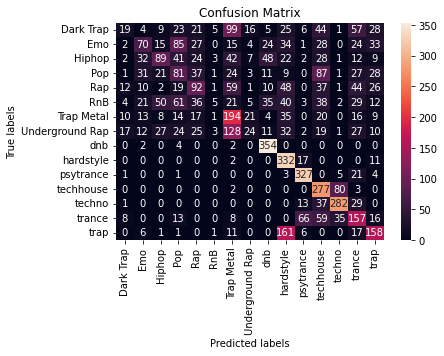

In [145]:
# Run Naive Bayes on sampled data.
gnb_sampled = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = cross_val_score(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy with Sampled/Balanced Non-Anomalous Data:", (avg_accuracy * 100))


# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier with balanced classes.
pred_labels_sampled = cross_val_predict(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)
con_mat_sampled = confusion_matrix(samp_genres, pred_labels_sampled)
plot_confusion_matrix(con_mat_sampled)

# Display the classification report for the Naive Bayes classifier with balanced classes.
report_sampled = classification_report(samp_genres, pred_labels_sampled, zero_division=0)
print("\nClassification Report with Sampled/Balanced Non-Anomalous Data:\n", report_sampled)

Using the completely balanced downsampled non-anomalous data, the accuracy of our classifer decreased by ~3% and ~6% from our whole data and non-anomalous classifiers, respectively. Although the accuracy decreased, this may actually indicate a more honest and fair representation of the classifier's performance on the dataset.


Notably, all genres receive some number of correct predictions (as opposed to Emo, Pop, and Rnb receiving no predictions in the previous two classifiers). Psytrance and dnb still remain as the best performing classes (f1 scores of 0.82 and 0.80, respectively), however Underground Rap saw a huge hit in its performance (a drop of ~0.30). This genre had the most songs in it originally, perhaps indicating a skew in genre performance based on number of points available in the dataset. 

Overall, the best performing Naive Bayes classifier was most likely the non-anomalous, imbalanced classifier (with the highest weighted precision, recall, and f1 score overall). However, after balancing the data via downsampling, the imbalanced classifier may have been skewed to improve accuracy in majority classes and ignore minority classes in its training.

### Decision Trees

#### Datasets for Decision Trees (No One-Hot Encoding)

In [146]:
features_dt = df_dt.drop('genre', axis=1)
labels_dt = df_dt['genre']

y_pred_list_dt = []

envelope_pred_dt = EllipticEnvelope().fit_predict(features_dt)
y_pred_list_dt.append(envelope_pred_dt)

# apply IsolationForest AD
forest_pred_dt = IsolationForest().fit_predict(features_dt)
y_pred_list_dt.append(forest_pred_dt)

# apply LocalOutlierFactor AD
lof_pred_dt = LocalOutlierFactor().fit_predict(features_dt)
y_pred_list_dt.append(lof_pred_dt)

features_no_anomalies_dt = features_dt.copy()
labels_no_anomalies_dt = labels_dt.copy()
anomaly_indices_dt = set()
for arr in y_pred_list_dt:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices_dt.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices_dt = list(anomaly_indices_dt)
anomaly_indices_dt.sort()
features_no_anomalies_dt = features_no_anomalies_dt.drop(anomaly_indices_dt, axis=0)
labels_no_anomalies_dt = labels_no_anomalies_dt.drop(anomaly_indices_dt, axis=0)

features_no_anomalies_dt = features_no_anomalies_dt.reset_index().drop('index', axis=1)
labels_no_anomalies_dt = labels_no_anomalies_dt.reset_index().drop('index', axis=1)
label_groups_dt = labels_no_anomalies_dt.groupby('genre')

min_size_dt = math.inf
for genre in label_groups_dt.groups.keys():
    genre_group_dt = label_groups_dt.get_group(genre)
    if len(genre_group_dt) < min_size_dt:
        min_size_dt = len(genre_group_dt)
num_samples_dt = min_size_dt

# Sample same number of points from each genre to balance classes.
samp_features_dt = []
samp_genres_dt = []
samp_records_dt = []
df_no_anomalies_dt = pd.DataFrame(features_no_anomalies_dt.copy())
df_no_anomalies_dt['genre'] = labels_no_anomalies_dt
genres_dt = df_no_anomalies_dt.groupby('genre')
for genre in genres_dt.groups.keys():
    genre_group_dt = genres.get_group(genre)
    genre_group_copy_dt = genre_group_dt.copy()
    genre_group_copy_dt = genre_group_copy_dt.reset_index()
    for i in range(num_samples_dt):
        index = random.randint(0, len(genre_group_copy_dt) - 1)
        samp_records_dt.append(genre_group_copy_dt.iloc[index, :])

samp_features_dt = pd.DataFrame(samp_records_dt).set_index('index')
samp_genres_dt = samp_features_dt['genre']
samp_features_dt = samp_features_dt.drop('genre', axis=1)

Counter({1: 38074, -1: 4231})
Counter({1: 37358, -1: 4947})
Counter({1: 40473, -1: 1832})


In [153]:
def decision_tree_clf(features, labels):
    dt_model = tree.DecisionTreeClassifier()
    parameters = {'criterion':["gini", "entropy"], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20], 'max_features': [5, 10, 15]}
    dt_grid = GridSearchCV(dt_model, parameters, scoring="accuracy", cv=10)
    
    y_pred = cross_val_predict(dt_grid, features, labels, cv=10)
    
    print(classification_report(labels, y_pred))
    dict_report = classification_report(labels, y_pred, output_dict=True)
    
    confusion_mat = confusion_matrix(labels, y_pred)
    plot_confusion_matrix(confusion_mat)

    return dict_report

#### Looking at data distribution

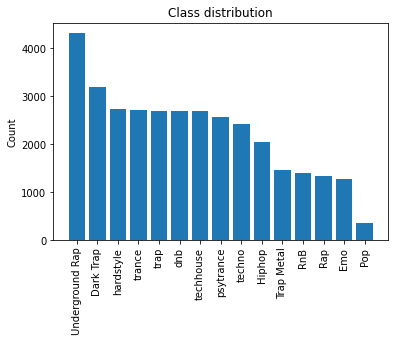

In [154]:
# Visualize label distribution in bar graph
labels_size = list(label_groups_dt.size())

genre_size = {k: v for k, v in zip(unique_genres, labels_size)}
sorted_f1_genre = {k: v for k, v in sorted(genre_size.items(), key=lambda item: item[1], reverse=True)}

x = list(sorted_f1_genre.keys())
y = list(sorted_f1_genre.values())

plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

#### Functions

##### Plot F1 score by genre

In [155]:
def plot_f1_score(class_report):
    
    f1_genre = {genre: class_report[genre]['f1-score'] for genre in unique_genres}
    
    sorted_f1_genre = {k: v for k, v in sorted(f1_genre.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_f1_genre.keys())
    y = list(sorted_f1_genre.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('F1-score')
    plt.title('F1-score for each genre')

    plt.show()
    
    return f1_genre

##### Cohesion

In [156]:
def cohesion_corr(df, f1_genre):
    rel_cohesion = dict()
    for genre in unique_genres:
        cohesion = 0
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid = np.mean(data, axis=0)
        for i in range(0, len(data)):
            record = data.iloc[i, :]
            cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
        rel_cohesion[genre] = cohesion / len(data)

    sorted_cohesion = {k: v for k, v in sorted(rel_cohesion.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_cohesion.keys())
    y = list(sorted_cohesion.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Cohesion')
    plt.title('Cohesion for each genre')

    plt.show()

    f1_genre_values = list(f1_genre.values())
    cohesion_values = list(rel_cohesion.values())

    plt.scatter(cohesion_values, f1_genre_values)

    plt.title("Scatterplot of Cohesion and F1 score")
    plt.xlabel("Cohesion")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Cohesion and F1 score", np.corrcoef(f1_genre_values, cohesion_values)[0][1])

##### Separation

In [157]:
def separation_corr(df, f1_genre):
    overall_centroid = np.mean(samp_features_dt, axis=0)
    separation_stats = dict()
    centroid_dict = dict()
    for genre in unique_genres:
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid_dict[genre] = np.mean(data, axis=0)
        crnt_centroid = np.mean(data, axis=0)
        dist = math.dist(overall_centroid, crnt_centroid) ** 2
        data_size = len(data)
        bss = dist * data_size
        separation_stats[genre] = bss

    sorted_separation = {k: v for k, v in sorted(separation_stats.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_separation.keys())
    y = list(sorted_separation.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Separation')
    plt.title('Separation for each genre')

    plt.show()

    f1_genre_values = list(f1_genre.values())
    separation_values = list(separation_stats.values())

    plt.scatter(separation_values, f1_genre_values)

    plt.title("Scatterplot of Seperation and F1 score")
    plt.xlabel("Seperation")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Sepearation and F1 score", np.corrcoef(f1_genre_values, separation_values)[0][1])

#### Train with data without anomalies

In [158]:
# Running decision tree in dataset without anomalies
dt_report = decision_tree_clf(features_no_anomalies_dt, labels_no_anomalies_dt)

In [ ]:
f1_genre = plot_f1_score(dt_report)
cohesion_corr(df_dt, f1_genre)
separation_corr(df_dt, f1_genre)

#### After Downsampling

In [ ]:
# Running decision tree after downsampling
dt_report = decision_tree_clf(samp_features_dt, samp_genres_dt)

In [ ]:
f1_genre = plot_f1_score(dt_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, f1_genre)
separation_corr(downsample_df, f1_genre)

#### Analysis

We decided that the decision tree model would be ideal for our task because we have lots of features and the decision tree model doesn't suffer from the curse of dimensionliaty. Also, we have combination of numerical and categorical features which makes our dataset ideal for using decision tree model.

We first tried to train the model on full dataset by splitting the dataset to train (.8) and test set (.2). We used grid search to find the most optimal hyperparameters for criterion, max_depth, min_samples_leaf, and max_features and use that hyperparameters to train the new model with train dataset and test it on the test dataset. We noticed that the certain genres achieve high accuracy while the others don't. Especially, the genres with more data tends to get higher accuracy. For example, the f-1 score of genre Pop was the lowest, and the number of data in original dataset was also the lowest.

Therefore, we downsampled the data to account for the class imbalance. After downsampling, we see that F-1 scores of genres are more evenly spread out. There are still genres that the model doesn't perform well. However, this is likely to due to the inherent characteristic of genre. For example, certain genre might be harder to distinguish than other genres because the values of features are similar to that of data from other genres.

Although the overall accuracy went down, we observe that genres that didn’t perform well before downsampling such as Pop perform much better.

We test whether there is correlation between WSS (Cohesion) and BSS (Separation) between how well the model performs on each genere (F1-score). For downsampled data, we get -0.82 as correlation coefficient between Cohesion and F1-score and 0.29 as that between Separation and F1-score. We see that there is stronger negative correlation between how cohesitive the data points in genre are and how well the model performs on that genre. We see there is positive correlation between how separable genre is from other genres and how well the model performs on that genre. However, there doesn't seem to be great positive correlation as the number is small and there are lots of genres where the WSS is close to 0.

### Random Forest

#### Function

In [ ]:
def random_forest_clf(features, labels):
    rf_model = RandomForestClassifier()
    rf_param = {'n_estimators': list(range(50, 150, 50))}
    
    rf_grid = GridSearchCV(rf_model, rf_param, scoring="accuracy", cv=10)
    y_pred = cross_val_predict(rf_grid, features, labels, cv=10)
    
    report = classification_report(labels, y_pred, output_dict=True)

    print(report)
    
    confusion_mat = confusion_matrix(labels, y_pred)
    plot_confusion_matrix(confusion_mat)
    
    # Importance of features
    importances = rf_grid.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=list(features.columns))

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    return report

#### Training

In [ ]:
rf_report = random_forest_clf(samp_features_dt, samp_genres_dt)

In [ ]:
rf_f1_genre = plot_f1_score(rf_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, rf_f1_genre)
separation_corr(downsample_df, rf_f1_genre)

#### Analysis

We decided to use random forest model because it is suitable for our dataset with same reason as decision tree. Random forest model is supposed to be better than decision tree because it predicts label by ensembling multiple decision trees and randomly selects a subset of input features rather than using all features for split. Thefore is better at not overfitting by relying on single best feature.

We see that random forest model performs much better than a single decision tree as the model's accuracy on test dataset went up signitificantly. When using only single decision tree, we got accuracy of 0.58. On same dataset, we get accuracy of 0.68.

We identify what features were most important by using mean decrease in impurity metrics. We see that tempo is the most imporatnt feature followed by duration of song as second most important feature. Features like mode and time signature were the least important features.

We see similar trend between cohesion measure and the model's performance on each genre and so as the separation measure. However, the absolute values of the correlation coefficient both went down.

### Neural Network

#### With Anomalies

In [ ]:
scaler = StandardScaler()
mlp_orig = MLPClassifier(random_state=1, early_stopping=True, max_iter=50)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_orig_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_orig)])
mlp_orig_grid = GridSearchCV(mlp_orig_pipe, mlp_param, n_jobs=-1, cv=5)
y_orig_pred = cross_val_predict(mlp_orig_grid, features, labels, cv=5)

In [ ]:
print('Results on the entire dataset:')
print (classification_report(labels, y_orig_pred))
orig_report = classification_report(labels, y_orig_pred, output_dict=True)
plot_f1_score(orig_report)

In [ ]:
print('Confusion matrix for the original dataset:')
cm_orig = metrics.confusion_matrix(labels,y_orig_pred)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm_orig, annot=True, fmt='g')
plt.show()

#### Without Anomalies

In [ ]:
mlp_noanom = MLPClassifier(random_state=1, early_stopping=True, max_iter=100)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_noanom_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_noanom)])
mlp_noanom_grid = GridSearchCV(mlp_noanom_pipe, mlp_param, n_jobs=-1, cv=5)
y_noanom_pred = cross_val_predict(mlp_noanom_grid, features_no_anomalies, labels_no_anomalies, cv=5)

In [ ]:
print('Results on the dataset without anomalies:')
noanom_report = classification_report(labels, y_noanom_pred, output_dict=True)
print (classification_report(labels, y_noanom_pred))
plot_f1_score(noanom_report)

In [ ]:
cm_noanom = metrics.confusion_matrix(labels_no_anomalies,y_noanom_pred)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm_noanom, annot=True, fmt='g')

#### Downsampled

In [ ]:
scaler = StandardScaler()
mlp_down = MLPClassifier(random_state=1, early_stopping=True, max_iter=50)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_down_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_down)])
mlp_down_grid = GridSearchCV(mlp_down_pipe, mlp_param, n_jobs=-1, cv=5)
y_down_pred = cross_val_predict(mlp_down_grid, samp_features, samp_genres, cv=5)

In [ ]:
print('Results on the downsampled dataset:')
down_report = classification_report(labels, y_noanom_pred, output_dict=True)
print (classification_report(labels, y_noanom_pred))
plot_f1_score(down_report)

In [ ]:
cm=metrics.confusion_matrix(samp_genres,y_down_pred)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g')

#### Analysis

<p>We decided to use a Neural Network because it is good to use when the data has a lot of inputs and there is a large quanitity of training data. Additionally, it does not suffer from the curse of dimensionality which is good for us since our data has a lot of features.

Using the entire dataset with 42305 records, the MLPClassifier predicted the correct genre with 66% accuracy.

Using the dataset with anomalies removed (according to the anomaly detection process from earlier), the model's accuracy increased slightly to 68%. This could be because the records that were considered edge cases (most unlike the other records in that class) have been removed so there are fewer records that are more likely to be misclassified by the model.

Using the downsampled dataset of size 5490 to mitigate for class imbalance (sampled same number of records from each class), the model's accuracy decreased to 59%. This could be because since the records from various classes are so similar (as proven by analysis on the clustering), having a lot of data was a strength of the dataset that allowed the model to pick up on more minute differences between records of different classes the more it trained. Now that there are much fewer records from each classes, it is harder for the model to differentiate between classes as well as before and it is more likely to misclassify.</p>

### KNN Classification

#### Downsampled Dataset

In [ ]:
knn_grid = {
    'pca__n_components': list(range(10, 16)),
    'knn__n_neighbors': list(range(5, 20)),
    'knn__weights': ['uniform', 'distance'],
}

knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=knn_grid, scoring='accuracy', cv=5)

knn_gscv.fit(samp_features, pd.Series(samp_genres['genre']).ravel())

print("KNN GridSearchCV Best Params: ", knn_gscv.best_params_)
print("KNN GridSearchCV Best Score", knn_gscv.best_score_)

In [ ]:
knn_pred = cross_val_predict(knn_gscv, samp_features, pd.Series(samp_genres['genre']).ravel(), cv=5)
knn_report = metrics.classification_report(y_true=pd.Series(samp_genres['genre']).ravel(), y_pred=knn_pred)

print("KNN Classifier Report")
print(knn_report)

#### Full Dataset

In [ ]:
param_grid = {
    'pca__n_components': list(range(10, 16)),
    'knn__n_neighbors': list(range(5, 20)),
    'knn__weights': ['uniform', 'distance'],
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("KNN GridSearchCV Best Params: ", knn_gscv.best_params_)
print("KNN GridSearchCV Best Score", knn_gscv.best_score_)

In [ ]:
knn_accs = cross_val_score(knn_gscv, features, labels, cv=5, scoring='accuracy')

print("Accuracy of KNN Classifier: ", np.average(knn_accs))
print()

knn_pred = cross_val_predict(knn_gscv, features, labels, cv=5)
knn_report = metrics.classification_report(y_true=labels, y_pred=knn_pred)

print("KNN Classifier Report")
print(knn_report)

### K-Means Clustering

#### Downsampled Dataset

In [ ]:
scaled_data = StandardScaler().fit_transform(features.values)
music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)
music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

# your code goes here
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(music_data_scaled)
music_data_pca = pd.DataFrame(pca_data)
music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

In [ ]:
samp_scaled_data = StandardScaler().fit_transform(samp_features.values)
samp_music_data_scaled = pd.DataFrame(samp_scaled_data, columns=features.columns)
samp_music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

# your code goes here
samp_pca = PCA(n_components=0.95, svd_solver='full')
samp_pca_data = samp_pca.fit_transform(samp_music_data_scaled)
samp_music_data_pca = pd.DataFrame(samp_pca_data)
samp_music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

In [ ]:
kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(samp_music_data_pca)
sil_score = silhouette_score(samp_music_data_pca, kpred, metric='euclidean')

print("Silhouette score for K-Means Clustering with k = 15", sil_score)

In [ ]:
""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column):
    vc = pd.Series(column).value_counts(sort=False)
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = samp_genres[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster['genre']))

print(cluster_names)
print(cluster_labels)
print (entropies)

In [ ]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = samp_music_data_pca[kpred == k]

    mds = MDS(n_components=3)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=colors[k])
    plt.show()

plt.show()

#### Full Dataset

In [ ]:
kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print("Silhouette score for K-Means Clustering with k = 15", sil_score)

In [ ]:
""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = labels[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster))

print(cluster_names)
print(cluster_labels)
print(entropies)

In [ ]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = music_data_pca[kpred == k]

    mds = MDS(n_components=3)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=colors[k])
    plt.show()

plt.show()

### Hierarchical Clustering

#### Downsampled Dataset

In [ ]:
def find_best_hier_params(centers):
    proximity_matrix = pdist(centers)
    methods = ['single', 'complete', 'average', 'centroid', 'ward']
    cpccs = []
    # the rest of your code goes here

    # Compute correlation for every linkage method and get the method with highest corr
    for method in methods:
        link_matrix = linkage(centers, method)
        cpcc, _ = cophenet(link_matrix, proximity_matrix)
        cpccs.append(cpcc)

    print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the highest CPCC of", np.amax(cpccs))
    
    return methods[np.argmax(cpccs)]

In [ ]:
centers = kmeans.cluster_centers_
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

In [ ]:
def silhouette_plot(music_data_pca, n_clusters=15):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

    cur_kpred = KMeans(n_clusters=n_clusters).fit_predict(music_data_pca)

    avg_sil_score = silhouette_score(music_data_pca, cur_kpred, metric='euclidean')
    sample_silhouette_values = silhouette_samples(music_data_pca, cur_kpred)

    y_lower = 10
    for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cur_kpred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

In [ ]:
silhouette_plot(samp_music_data_pca, n_clusters=15)

In [ ]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(samp_music_data_pca)
    ith_sil_score = silhouette_score(samp_music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

#### Full Dataset

In [ ]:
centers = kmeans.cluster_centers_
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

In [ ]:
silhouette_plot(music_data_pca, n_clusters=15)

In [ ]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

### Custom Supervised Clustering Algorithm using KMeans and KNN

#### Downsampled Dataset

In [ ]:
def kmeans_per_label(music_data_pca, labels, clusters_per_label=5):

    pca_df = pd.concat([pd.DataFrame(music_data_pca), pd.DataFrame(labels).reset_index(drop=True)], axis=1)

    group_labels = pca_df.groupby('genre')
    all_genres = pca_df['genre'].unique()

    all_centroids = []
    centroid_labels = []

    for genre in all_genres:
        cur_group = group_labels.get_group(genre)

        group_data = cur_group.drop('genre', axis=1)
        cur_kmeans = KMeans(n_clusters=clusters_per_label)
        cur_kmeans.fit_predict(group_data)
        
        for centroid in cur_kmeans.cluster_centers_:
            all_centroids.append(centroid)
            centroid_labels.append(genre)

    return (all_centroids, centroid_labels)

In [ ]:
all_centroids, _ = kmeans_per_label(samp_music_data_pca, samp_genres, 5)
hier2 = linkage(all_centroids, find_best_hier_params(all_centroids))
plt.figure()
dn2 = dendrogram(hier2)
plt.show()

In [ ]:
class KCentroidsClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clusters_per_label=5, n_neighbors=5, *,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=None,
                 **kwargs):
        
        self.centroids_ = None
        self.classes_ = None
        self.clusters_per_label = clusters_per_label
        self.weights = weights
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.knn_ = KNeighborsClassifier(n_neighbors=n_neighbors,
                 weights=weights, algorithm=algorithm, leaf_size=leaf_size,
                 p=2, metric=metric, metric_params=metric_params, n_jobs=n_jobs,
                 **kwargs)
        
    def fit(self, X, y):
        self.centroids_, self.classes_ = kmeans_per_label(X, y, self.clusters_per_label)
        self.knn_.fit(self.centroids_, self.classes_)
        return self
    
    def predict(self, X):
        kpred = self.knn_.predict(X)
        return kpred
    
    def predict_proba(self, X):
        return self.knn_.predict_proba(X)

In [ ]:
kcc = KCentroidsClassifier(clusters_per_label=5, n_neighbors=1)
kcc.fit(samp_music_data_pca, samp_genres)

kcc_pred = kcc.predict(samp_music_data_pca)
print (metrics.accuracy_score(samp_genres, kcc_pred))

In [ ]:
kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, svd_solver='full')), ('kcc', KCentroidsClassifier(clusters_per_label=5, n_neighbors=10, weights='distance'))])

pipe_pred = cross_val_score(kcc_pipe, samp_features, samp_genres, cv=5, scoring='accuracy')

print(np.average(pipe_pred))

In [ ]:
kcc_param_grid = {
    'pca__n_components': list(range(11, 16)),
    'kcc__n_neighbors': list(range(1, 5)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 6))
}

kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kcc', KCentroidsClassifier())])

kcc_gscv = GridSearchCV(estimator=kcc_pipe, param_grid=kcc_param_grid, scoring='accuracy', cv=5)

kcc_gscv.fit(samp_features, samp_genres)

print("KCentroidsClassifier GridSearchCV Best Params: ", kcc_gscv.best_params_)
print("KCentroidsClassifier GridSearchCV Best Score", kcc_gscv.best_score_)

In [ ]:
kcc_pred = cross_val_predict(kcc_gscv, samp_features, samp_genres, cv=5)
kcc_report = metrics.classification_report(y_true=samp_genres, y_pred=kcc_pred)

print("KCC Classifier Report")
print(kcc_report)

#### Full Dataset

In [ ]:
all_centroids, _ = kmeans_per_label(music_data_pca, labels, 5)
hier2 = linkage(all_centroids, find_best_hier_params(all_centroids))
plt.figure()
dn2 = dendrogram(hier2)
plt.show()

In [ ]:
kcc = KCentroidsClassifier(clusters_per_label=5, n_neighbors=1)
kcc.fit(music_data_pca, labels)

kcc_pred = kcc.predict(music_data_pca)
print (metrics.accuracy_score(labels, kcc_pred))

In [ ]:
kcc_param_grid = {
    'pca__n_components': list(range(5, 16)),
    'kcc__n_neighbors': list(range(1, 10)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 5))
}


kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, svd_solver='full')), ('kcc', KCentroidsClassifier(clusters_per_label=5, n_neighbors=10, weights='distance'))])

pipe_pred = cross_val_score(kcc_pipe, features, labels, cv=5, scoring='accuracy')

print(np.average(pipe_pred))

In [ ]:
kcc_param_grid = {
    'pca__n_components': list(range(11, 16)),
    'kcc__n_neighbors': list(range(1, 5)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 6))
}

kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kcc', KCentroidsClassifier())])

kcc_gscv = GridSearchCV(estimator=kcc_pipe, param_grid=kcc_param_grid, scoring='accuracy', cv=5)

kcc_gscv.fit(features, labels)

print("KCentroidsClassifier GridSearchCV Best Params: ", kcc_gscv.best_params_)
print("KCentroidsClassifier GridSearchCV Best Score", kcc_gscv.best_score_)

In [ ]:
kcc_accs = cross_val_score(kcc_gscv, features, labels, cv=5, scoring='accuracy')

print("Accuracy of KCentroidsClassifier: ", np.average(kcc_accs))

kcc_pred = cross_val_predict(kcc_gscv, features, labels, cv=5)
kcc_report = metrics.classification_report(y_true=labels, y_pred=kcc_pred)

print("KCC Classifier Report")
print(kcc_report)